In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
import torch
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import textwrap
from summarization import sliding_window_summarization

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
# Replace 'file_path.pkl' with the path to your .pkl file
df = pd.read_pickle("../results_2024_11_09_112019/articles.pkl")

In [3]:
# convert dictionary to dataframe
df = pd.DataFrame(df)
df.head(3)

,PMC11315657,PMC11204383,PMC11301388,PMC11240861,PMC11289611,PMC11286288,PMC11315276,PMC11312292,PMC11308427,PMC11303826,...,PMC11180946,PMC11097100,PMC11096445,PMC11284501,PMC10749615,PMC11152865,PMC11293442,PMC11152559,PMC10749592,PMC11213448
TITLE,[Exploring the association between melatonin a...,[Antibodies Against ZSCAN1 in Pediatric and Ad...,[Gingival mesenchymal stem cells: Biological p...,[Research progress of DNA methylation in color...,[Investigating the Relationship of Serum CD163...,[Genetic Associations With an Amyotrophic Late...,[The aperiodic exponent of neural activity var...,[mTOR activation induces endolysosomal remodel...,[Mendelian randomization study on causal assoc...,[Pooling Alzheimer's disease clinical trial da...,...,[The 2022 symposium on dementia and brain agin...,[Hyperbaric oxygen therapy: future prospects i...,[Dangers of the chronic stress response in the...,[Cortical similarities in psychiatric and mood...,[The autophagy protein Atg9 functions in glia ...,[Role of erythropoietin in the treatment of Al...,[CNTN4 modulates neural elongation through int...,[Evaluating protein prenylation of human and v...,[Mitophagy in neurodegenerative disease pathog...,[“The burden of lifestyle diseases and their i...
ABSTRACT,[Due to the addictive qualities of tobacco pro...,"[Objectives, To report the association of zinc...",[Our understanding of mesenchymal stem cells (...,[DNA methylation is one of the earliest and mo...,"[Objective, This study aimed to compare serum ...","[Background and Objectives, The term “ALS Reve...",[Recently the 1/f signal of human electroencep...,[Astrocytes respond and contribute to neuroinf...,"[Background, Previous research has revealed th...","[Abstract, With the advent of the first genera...",...,"[Abstract, Two of every three persons living w...",[Hyperbaric Oxygen Therapy (HBOT) utilizes 100...,[More than 20% of American adults live with a ...,"[Summary, Structural neuroimaging studies have...",[Parkinson’s disease is a progressive neurodeg...,[This review aims to explore the potential of ...,[The neuronal cell adhesion molecule contactin...,"[ABSTRACT, Prenylated proteins are prevalent i...",[Mitochondria are critical cellular energy res...,"[ABSTRACT, Basically, non-communicable disease..."
INTRO,"[Introduction, Nicotine dependence, a pervasiv...","[Introduction, Rapid-onset obesity with hypoth...","[Introduction, Mesenchymal stem cells, In the ...","[Introduction, Colorectal cancer (CRC) is one ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...","[Introduction, Amyotrophic lateral sclerosis (...","[Introduction, Pink noise or 1/f signals is a ...","[Introduction, Astrocytes maintain homeostasis...","[Introduction, Pulmonary arterial hypertension...","[INTRODUCTION, Alzheimer's disease is the most...",...,"[INTRODUCTION, Approximately 50 million people...","[Introduction, Hyperbaric oxygen therapy (HBOT...","[Introduction, Over 1 in 5 youth and adults li...","[Introduction, Mental illness can be severe, c...","[Introduction, Parkinson’s disease (PD) is a n...","[Introduction, Highlights, Oxidative stress da...","[Introduction, Neurodevelopmental disorders su...","[INTRODUCTION, Post-translational modification...","[Introduction, Neurons are the basic structura...","[Introduction and Background, Lifestyle diseas..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, TITLE to CONCL
Columns: 500 entries, PMC11315657 to PMC11213448
dtypes: object(500)
memory usage: 31.3+ KB


In [5]:
# transpose the dataframe and add an index column
df = df.T.reset_index()
df.head()

,index,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."
3,PMC11240861,[Research progress of DNA methylation in color...,[DNA methylation is one of the earliest and mo...,"[Introduction, Colorectal cancer (CRC) is one ...",[],"[Availability of data and materials, Not appli...",[],[],"[Conclusions and outlook, The research prospec..."
4,PMC11289611,[Investigating the Relationship of Serum CD163...,"[Objective, This study aimed to compare serum ...","[INTRODUCTION, Autism spectrum disorder (ASD) ...",[],"[METHODS, Sample of the Study, Forty children ...","[RESULTS, Table 1 presents the data regarding ...","[DISCUSSION, In this study, the serum CD163, Y...",[]


In [6]:
# change the first column name to 'article_id'
df = df.rename(columns={"index": "article_id"})
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,[Exploring the association between melatonin a...,[Due to the addictive qualities of tobacco pro...,"[Introduction, Nicotine dependence, a pervasiv...",[],[Considering individual differences in treatme...,[],[],"[Future research directions and conclusions, F..."
1,PMC11204383,[Antibodies Against ZSCAN1 in Pediatric and Ad...,"[Objectives, To report the association of zinc...","[Introduction, Rapid-onset obesity with hypoth...",[],"[Methods, Patients and Samples, Thirteen patie...","[Results, ZSCAN1-abs were identified in 5 of 6...","[Discussion, The discovery of ZSCAN1-abs as a ...",[]
2,PMC11301388,[Gingival mesenchymal stem cells: Biological p...,[Our understanding of mesenchymal stem cells (...,"[Introduction, Mesenchymal stem cells, In the ...",[],"[Source, isolation, culture method, and prelim...",[],"[Limitations on GMSC practical use, Despite th...","[Conclusion, Over the last two decades, intere..."


In [7]:
# Convert all lists in the DataFrame to strings
df = df.apply(
    lambda x: x.map(lambda y: ", ".join(map(str, y)) if isinstance(y, list) else y),
    axis=0,
)

df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",,Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",,"Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [8]:
# Check for missing values after converting lists to strings
df.isnull().sum()

article_id    0
TITLE         0
ABSTRACT      0
INTRO         0
CASE          0
METHODS       0
RESULTS       0
DISCUSS       0
CONCL         0
dtype: int64

In [9]:
# Replace empty strings with NaN
df = df.replace("", float("NaN"))
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,CASE,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",NaN,Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...",NaN,"Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...",NaN,"Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [10]:
# Check for missing values after replacing empty strings with NaN
df.isnull().sum()

article_id      0
TITLE           0
ABSTRACT        0
INTRO           3
CASE          496
METHODS       146
RESULTS       201
DISCUSS       137
CONCL         198
dtype: int64

In [11]:
# CASE column: 496 missing out of 500 (99.2% missing) — Droping the column
df = df.drop(columns=["CASE"])
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,NaN,NaN,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",NaN
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",NaN,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [12]:
# replace NaN values with empty strings
df = df.fillna("")
df.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu..."
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes..."


In [13]:
# save the dataframe to a .csv file
# df.to_csv(
#     "articles.csv", index=False
# )

In [14]:
# Method to recreate the articles minus the abstracts
def combine_columns(df):
    """
    Combines the text from multiple columns into a single column for natural language processing.

    Args:
      df: A pandas DataFrame with columns 'article_id', 'TITLE', 'INTRO', 'CASE', 'METHODS', 'RESULTS', 'DISCUSS', 'CONCL'.

    Returns:
      A pandas DataFrame with a new column 'full_text' containing the combined text.
    """

    df["full_text"] = df.apply(
        lambda row: " ".join(
            [
                str(row["TITLE"]),
                str(row["INTRO"]),
                str(row["METHODS"]),
                str(row["RESULTS"]),
                str(row["DISCUSS"]),
                str(row["CONCL"]),
            ]
        ),
        axis=1,
    )
    return df

In [15]:
df_articles = combine_columns(df)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [16]:
# Strip whitespace from each cell in the DataFrame
df_articles = df_articles.apply(
    lambda x: x.map(lambda y: y.strip() if isinstance(y, str) else y), axis=0
)
df_articles.head(3)

,article_id,TITLE,ABSTRACT,INTRO,METHODS,RESULTS,DISCUSS,CONCL,full_text
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...,"Introduction, Nicotine dependence, a pervasive...",Considering individual differences in treatmen...,,,"Future research directions and conclusions, Fu...",Exploring the association between melatonin an...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ...","Introduction, Rapid-onset obesity with hypotha...","Methods, Patients and Samples, Thirteen patien...","Results, ZSCAN1-abs were identified in 5 of 6 ...","Discussion, The discovery of ZSCAN1-abs as a b...",,Antibodies Against ZSCAN1 in Pediatric and Adu...
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...,"Introduction, Mesenchymal stem cells, In the e...","Source, isolation, culture method, and prelimi...",,"Limitations on GMSC practical use, Despite the...","Conclusion, Over the last two decades, interes...",Gingival mesenchymal stem cells: Biological pr...


In [17]:
wrapper = textwrap.TextWrapper(width=80, break_long_words=False, break_on_hyphens=False)

In [18]:
# Method to print the full text of a single article by article_id
def print_article(df, article_id):
    """
    Prints the full text of a single article in a readable format.

    Args:
      df: A pandas DataFrame with a 'full_text' column and an 'article_id' column.
      article_id: The ID of the article to print.
    """

    article = df[df["article_id"] == article_id]["full_text"].values[0]

    print(wrapper.fill(article))

In [19]:
# get a random article_id
article_id = df_articles.sample()["article_id"].values[0]
# print the full text of a random article_id
print_article(df_articles, article_id)

European and African-specific plasma protein-QTL and metabolite-QTL analyses
identify ancestry-specific T2D effector proteins and metabolites Introduction,
Human genetics studies have mainly focused on participants of European ancestry.
However, there has been a recent increase in studies that include multiple
ancestral backgrounds. With these efforts, human geneticists now have published
numerous studies on complex diseases that encompass multiple populations or
specifically target non-European populations. For example, two of the largest
studies on type-2 diabetes (T2D) included participants of five different
ancestries - Europeans, Africans, Hispanics, East Asians, and South Asians.
However, there has been a lack of utilization of ancestry-matched deep molecular
phenotyping datasets in post-GWAS analyses, namely colocalization, Mendelian
Randomization or trait-imputation (such as Transcriptome-wide association study
(TWAS) for RNA expression). These approaches are pivotal to priorit

In [20]:
# print article abstract
def print_abstract(df, article_id):
    """
    Prints the abstract of a single article in a readable format.

    Args:
      df: A pandas DataFrame with an 'article_id' column and a 'ABSTRACT' column.
      article_id: The ID of the article to print.
    """

    abstract = df[df["article_id"] == article_id]["ABSTRACT"].values[0]

    print(wrapper.fill(abstract))


print_abstract(df, article_id)

Initially focused on the European population, multiple genome-wide association
studies (GWAS) of complex diseases, such as type-2 diabetes (T2D), have now
extended to other populations. However, to date, few ancestry-matched omics
datasets have been generated or further integrated with the disease GWAS to
nominate the key genes and/or molecular traits underlying the disease risk loci.
In this study, we generated and integrated plasma proteomics and metabolomics
with array-based genotype datasets of European (EUR) and African (AFR)
ancestries to identify ancestry-specific muti-omics quantitative trait loci
(QTLs). We further applied these QTLs to ancestry-stratified T2D risk to
pinpoint key proteins and metabolites underlying the disease-associated genetic
loci. We nominated five proteins and four metabolites in the European group and
one protein and one metabolite in the African group to be part of the molecular
pathways of T2D risk in an ancestry-stratified manner. Our study demonstra

array([[<Axes: title={'center': 'full_text_length'}>,
        <Axes: title={'center': 'abstract_length'}>]], dtype=object)

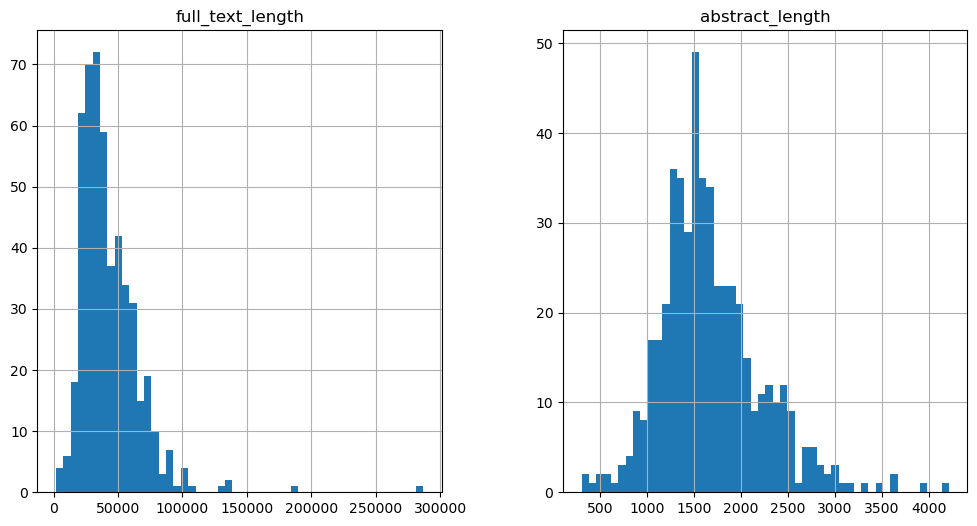

In [21]:
# create two lists 'full_text_length' and 'abstract_length' to store the length of each article and its abstract
full_text_length = []
abstract_length = []

# iterate through each row in the DataFrame
for index, row in df_articles.iterrows():
    # calculate the length of the 'full_text' and 'ABSTRACT' columns
    full_text_length.append(len(row["full_text"]))
    abstract_length.append(len(row["ABSTRACT"]))

data = pd.DataFrame([full_text_length, abstract_length]).T
data.columns = ["full_text_length", "abstract_length"]

data.hist(bins=50, figsize=(12, 6))

In [22]:
# Average length of full_text
data["full_text_length"].mean()
# Average length of abstract
data["abstract_length"].mean()

print("Average length of full_text:", data["full_text_length"].mean())
print("Average length of abstract:", data["abstract_length"].mean())

Average length of full_text: 42918.23
Average length of abstract: 1677.278


In [23]:
# Check for GPU support on Windows/Linux (CUDA) or MacOS (MPS)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [24]:
# Get a random index from the DataFrame
index = df_articles.sample().index[0]
# Get the full text of the article at the random index
article = df_articles.loc[index, "full_text"]
abstract = df_articles.loc[index, "ABSTRACT"]

In [25]:
print("Article:")
print(wrapper.fill(article))

Article:
Current View on PPAR-α and Its Relation to Neurosteroids in Alzheimer’s Disease
and Other Neuropsychiatric Disorders: Promising Targets in a Therapeutic
Strategy 1. Introduction, Alzheimer’s disease (AD) and several other
neuropsychiatric disorders are among the most significant unsolved medical and
social problems. Despite intensive studies and significant progress in genetics
and molecular biology, the pathomechanism/pathogenesis of AD and most other
neurodegenerative/neuropsychiatric diseases such as Parkinson’s disease (PD),
Huntington’s disease (HD), and schizophrenia has not been fully elucidated, and
therapeutic approaches are still not effective. Several million people around
the world are waiting for novel or repurposing drugs that will be able to retard
or ameliorate neurodegeneration. Unfortunately, along with major progress in
several fields of science and technology, an increase in psychiatric disorders
has been noticed. In the last decades, a significant rise in 

In [26]:
print("Abstract:")
print(wrapper.fill(abstract))

Abstract:
Peroxisome proliferator-activated receptors (PPARs) may play an important role
in the pathomechanism/pathogenesis of Alzheimer’s disease (AD) and several other
neurological/neuropsychiatric disorders. AD leads to progressive alterations in
the redox state, ion homeostasis, lipids, and protein metabolism. Significant
alterations in molecular processes and the functioning of several signaling
pathways result in the degeneration and death of synapses and neuronal cells,
leading to the most severe dementia. Peroxisome proliferator-activated receptor
alpha (PPAR-α) is among the processes affected by AD; it regulates the
transcription of genes related to the metabolism of cholesterol, fatty acids,
other lipids and neurotransmission, mitochondria biogenesis, and function.
PPAR-α is involved in the cholesterol transport to mitochondria, the substrate
for neurosteroid biosynthesis. PPAR-α-coding enzymes, such as sulfotransferases,
which are responsible for neurosteroid sulfation. The 

In [27]:
# find the number of tokens in the article
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
tokens = tokenizer(article, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the article:", num_tokens)

Number of tokens in the article: 8359


In [28]:
# find the number of tokens in the abstract
tokens = tokenizer(abstract, return_tensors="pt")
num_tokens = tokens.input_ids.shape[1]
print("Number of tokens in the abstract:", num_tokens)

Number of tokens in the abstract: 320


In [29]:
def summarize_article_with_model(
    article: str,
    model_name: str = "t5-small",
    max_length: int = 512,
    overlap: int = 128,
    redundancy_threshold: float = 0.8,
    summary_length: int = 300,
) -> str:
    """
    Summarizes an article using a specified model and the sliding window summarization method.

    Args:
        article (str): The article to summarize.
        model_name (str): The model name to use for summarization (default is 't5-small').
        max_length (int): Maximum token length for each chunk (default is 512).
        overlap (int): The number of tokens to overlap between chunks (default is 128).
        redundancy_threshold (float): The cosine similarity threshold for redundancy reduction (default is 0.8).
        summary_length (int): The maximum length of the summary (default is 100 characters).

    Returns:
        str: The summarized article.
    """
    # Initialize tokenizer and pipeline for summarization
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    summarization_pipeline = pipeline("summarization", model=model_name)

    # Call the sliding window summarization function
    summary = sliding_window_summarization(
        text=article,
        tokenizer=tokenizer,
        pipe=summarization_pipeline,
        max_length=max_length,
        overlap=overlap,
        redundancy_threshold=redundancy_threshold,
        summary_length=summary_length,
    )

    return summary

### [facebook/bart-large-cnn](https://huggingface.co/facebook/bart-large-cnn)
Facebook BART is a powerful language model from Facebook AI Research, known for its strong performance in text generation tasks like summarization. It combines the strengths of BERT and GPT by using a bidirectional encoder and an autoregressive decoder. BART is pre-trained by corrupting text and learning to reconstruct it, making it robust and versatile.

In [30]:
# Summarize the article using the BART model
model_name = "facebook/bart-large-cnn"

# Iitialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

c:\Users\stanl\OneDrive\Documents\codes\research_summarizer\research_summarizer\summarization.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(previous_summary_embedding).clone().detach()


Skipping redundant summary (similarity 0.869)
Skipping redundant summary (similarity 0.936)
Skipping redundant summary (similarity 0.867)
Skipping redundant summary (similarity 0.942)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Skipping redundant summary (similarity 0.816)
Skipping redundant summary (similarity 0.990)
Skipping redundant summary (similarity 0.867)
Summary:
Alzheimer’s disease (AD) and several other neuropsychiatric disorders are among
the most significant unsolved medical and social problems. Despite intensive
studies and significant progress in genetics and molecular biology, the
pathomechanism/pathogenesis of AD and most other
neurodegenerative/neuropsychiatric diseases has not been fully elucidated. In
all these diseases, alterations in peroxisome proliferator-activated receptor
(PPAR-α, PPAR-γ) signaling may play a crucial pathogenic role.  PPAR-α is
engaged in cholesterol metabolism and the biosynthesis of neurosteroids. The
receptor plays a crucial role in neurotransmission processes in glutamatergic,
cholinergic, and dopaminergic systems. It is also engaged in the regulation of
mitophagy/autophagy and neuronal death pathways.


In [31]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.21374045801526717, 'rouge2': 0.010230179028132993, 'rougeL': 0.13231552162849872, 'rougeLsum': 0.13231552162849872}


### [Falconsai/medical_summarization](https://huggingface.co/Falconsai/medical_summarization)

The T5 Large for Medical Text Summarization is a specialized version of the T5 language model, fine-tuned to create concise summaries of medical documents, research papers, and clinical notes. It's trained on a vast collection of medical literature and optimized with specific settings to ensure high-quality summaries. This model aims to help medical professionals quickly access crucial information from complex medical texts.

In [32]:
# Summarize an article using the Falconsai/medical_summarization
model_name = "Falconsai/medical_summarization"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (9598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


Skipping redundant summary (similarity 0.929)
Skipping redundant summary (similarity 0.834)
Skipping redundant summary (similarity 0.861)
Skipping redundant summary (similarity 0.854)
Skipping redundant summary (similarity 0.803)


Your max_length is set to 200, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


Summary:
background : peroxisome proliferator-activated receptor (PPAR-) is a potent
transcription factor that regulates genes related to fatty acids (FA) transport
and oxidation, cholesterol transport/sulfation, and triglyceride (TG) metabolism
. it regulates the transcription of various neuronal plasticity through genomic
and non-genomic pathways . the role of PPARs in Alzheimer’s disease and other
neuropsychiatric disorders has not been fully elucidated , and therapeutic
approaches are still not effective.results:in the last decades, a significant
rise in psychosis, depression, schizophrenia, and several neurodevelopmental
diseases, including autism spectrum disorder (ASD) and attention deficit
hyperactivity disorder (ADHD) , has been reported.


In [33]:
# Evaluate the Falconsai/medical_summarization model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.14545454545454545, 'rouge2': 0.005221932114882507, 'rougeL': 0.0987012987012987, 'rougeLsum': 0.0987012987012987}


[google/bigbird-pegasus-large-pubmed](https://huggingface.co/google/bigbird-pegasus-large-pubmed)

BigBird-Pegasus is a Google AI model that excels at summarizing long documents. It combines the Pegasus architecture with BigBird's attention mechanism, allowing it to handle texts up to 8000 words long (4096 tokens). This makes it ideal for tasks like summarizing articles, reports, and scientific papers, opening up new possibilities for NLP applications that require understanding lengthy content.

In [34]:
# Summarize an article using the "google/bigbird-pegasus-large-pubmed" model
model_name = "google/bigbird-pegasus-large-pubmed"

# Initialize the tokenizer and pipeline for summarization
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# Call the sliding window summarization function
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=3968,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (7820 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 3914 to 3968 to be a multiple of `config.block_size`: 64
Input ids are automatically padded from 3891 to 3904 to be a multiple of `config.block_size`: 64
Attention type 'block_sparse' is not possible if sequence_length: 394 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Summary:
neuroblastoma is a childhood solid tumor composed of primitive cells derived
from precursors of the autonomic nervous system .<n> this neoplasm has a high
rate of recurrence , which is further increased by the presence of environmental
factors , such as cigarette smoke , alcohol , food , and nutrition . in this
paper<n> , we will focus on how genetic and environmental factors affect the
development of neuroblastoma . in particular , we will focus on the interaction
between genetic and environmental factors that determine the pattern of
neuroblast differentiation and the progression of the disease . in recent years
, advances in genetic technology have enabled the synthesis of small interfering
rnas ( sirnas ) and cdk1 inhibitors for the treatment of solid tumors . these
sirnas target genes involved in cell proliferation , survival , migration , and
tumorigenesis .


In [35]:
# Evaluate the "google/bigbird-pegasus-large-pubmed" model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.20772946859903382, 'rouge2': 0.01941747572815534, 'rougeL': 0.1400966183574879, 'rougeLsum': 0.1400966183574879}


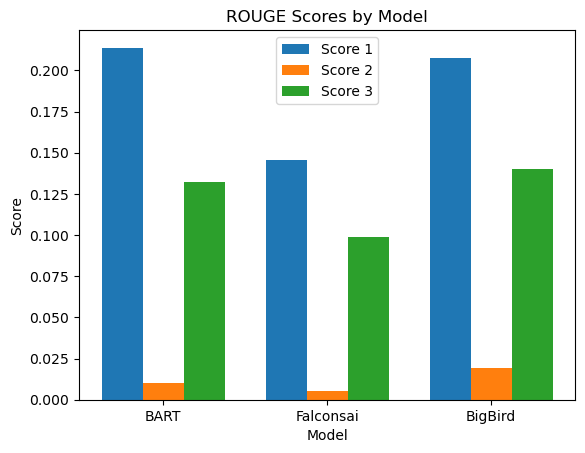

In [36]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

## Let's compare using the slinding window function vs a split into chunks method

In [37]:
def split_into_chunks(text, tokenizer, max_tokens):
    """
    Splits the text into chunks of `max_tokens` length without breaking sentences.
    """
    tokens = tokenizer.encode(text, truncation=False)
    chunks = []
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i + max_tokens]
        chunk = tokenizer.decode(chunk_tokens, skip_special_tokens=True)
        chunks.append(chunk)
    return chunks

In [38]:
def summarize_text(text, model_name="facebook/bart-large-cnn", max_tokens=1024, summary_max_length=130):
    """
    Summarizes a long article by splitting it into chunks if necessary.
    
    Args:
        text (str): The long text to summarize.
        model_name (str): Hugging Face model name for summarization.
        max_tokens (int): Maximum tokens per chunk.
        summary_max_length (int): Max length of the summary for each chunk.
        
    Returns:
        str: The combined summary.
    """
    # Detect if GPU is available and set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    
    # Split text into chunks
    chunks = split_into_chunks(text, tokenizer, max_tokens)
    print(f"Text split into {len(chunks)} chunks.")
    
    # Summarize each chunk
    summaries = []
    for idx, chunk in enumerate(chunks):
        print(f"Summarizing chunk {idx + 1}/{len(chunks)}...")
        inputs = tokenizer(chunk, return_tensors="pt", max_length=max_tokens, truncation=True).to(device)
        outputs = model.generate(
            inputs["input_ids"], 
            max_length=summary_max_length, 
            min_length=30, 
            length_penalty=2.0, 
            num_beams=4
        )
        summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
        summaries.append(summary)
    
    # Combine all summaries
    combined_summary = " ".join(summaries)
    return combined_summary

In [39]:
# Summarize the article using the BART model
summary = summarize_text(article, model_name="facebook/bart-large-cnn", max_tokens=1024, summary_max_length=130)
print("Summary:")
print(wrapper.fill(summary))

Using device: cuda
Text split into 9 chunks.
Summarizing chunk 1/9...
Summarizing chunk 2/9...
Summarizing chunk 3/9...
Summarizing chunk 4/9...
Summarizing chunk 5/9...
Summarizing chunk 6/9...
Summarizing chunk 7/9...
Summarizing chunk 8/9...
Summarizing chunk 9/9...
Summary:
Alzheimer’s disease (AD) and several other neuropsychiatric disorders are among
the most significant unsolved medical and social problems. The
pathomechanism/pathogenesis of AD and most other
neurodegenerative/neuropsychiatric diseases has not been fully elucidated.
Agonists of PPAR-α exert several positive effects on these disorders. PPARs
regulate cell metabolism through genomic and non-genomic pathways. PPAR-α may
exert neuroprotection through the regulation of genes involved in several
signaling pathways. Cholesterol is the substrate for neurosteroids, and its
level may influence the synthesis of progesterone, allopregnanolone, and other
compounds. In AD, the accumulation of cholesterol in mitochondria may a

In [40]:
# Evaluate the BART model on the first article
rouge = evaluate.load("rouge")
bart_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bart_scores)

{'rouge1': 0.2881844380403458, 'rouge2': 0.02601156069364162, 'rougeL': 0.1440922190201729, 'rougeLsum': 0.1440922190201729}


In [43]:
# Summarize the article using the "google/bigbird-pegasus-large-pubmed" model
summary = summarize_text(article, model_name="google/bigbird-pegasus-large-pubmed", max_tokens=2048, summary_max_length=130)
print("Summary:")
print(wrapper.fill(summary))

Using device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (7821 > 4096). Running this sequence through the model will result in indexing errors
Input ids are automatically padded from 2015 to 2048 to be a multiple of `config.block_size`: 64


Text split into 4 chunks.
Summarizing chunk 1/4...


Input ids are automatically padded from 2028 to 2048 to be a multiple of `config.block_size`: 64


Summarizing chunk 2/4...


Input ids are automatically padded from 2006 to 2048 to be a multiple of `config.block_size`: 64


Summarizing chunk 3/4...


Input ids are automatically padded from 1646 to 1664 to be a multiple of `config.block_size`: 64


Summarizing chunk 4/4...
Summary:
neuropsychiatric disorders are becoming an increasingly common problem in
developed countries .<n> this can be due to several reasons , including the
ageing of the population , increasing pressure to provide for the mental health
needs of children and adolescents , and socioeconomic problems .<n> however ,
the mechanisms underlying the development and progression of neuropsychiatric
disorders remain poorly understood .<n> for example , it has not been possible
to establish whether there is an increased risk of certain neuropsychiatric
disorders , such as autism spectrum disorders ( asd ) , in older individuals
.<n> the genetic basis of this risk remains unclear steroid receptors , which
are found in the brain , play an important role in the development and
homeostasis of the central nervous system ( cns ) . in this review article , the
authors will focus on the role of cholesterol metabolism in the cns and in the
pathogenesis of neuropsychiatric disord

In [44]:
# Evaluate the "google/bigbird-pegasus-large-pubmed" model on the first article
bigbird_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(bigbird_scores)

{'rouge1': 0.2481536189069424, 'rouge2': 0.03259259259259259, 'rougeL': 0.16838995568685378, 'rougeLsum': 0.16838995568685378}


In [45]:
# Summarize the article using the "Falconsai/medical_summarization" model
summary = summarize_text(article, model_name="Falconsai/medical_summarization", max_tokens=512, summary_max_length=130)
print("Summary:")
print(wrapper.fill(summary))

Using device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (9599 > 512). Running this sequence through the model will result in indexing errors


Text split into 19 chunks.
Summarizing chunk 1/19...
Summarizing chunk 2/19...
Summarizing chunk 3/19...
Summarizing chunk 4/19...
Summarizing chunk 5/19...
Summarizing chunk 6/19...
Summarizing chunk 7/19...
Summarizing chunk 8/19...
Summarizing chunk 9/19...
Summarizing chunk 10/19...
Summarizing chunk 11/19...
Summarizing chunk 12/19...
Summarizing chunk 13/19...
Summarizing chunk 14/19...
Summarizing chunk 15/19...
Summarizing chunk 16/19...
Summarizing chunk 17/19...
Summarizing chunk 18/19...
Summarizing chunk 19/19...
Summary:
background : peroxisome proliferator-activated receptor (PPAR-) and its
relationship to neurosteroids in Alzheimer’s disease and other neuropsychiatric
disorders are among the most significant unsolved medical and social problems.
despite intensive studies and significant progress in genetics and molecular
biology, the pathomechanism/pathogenesis of AD and most other
neurodegenerative/neuropsychiatric diseases such as Alzheimer’s disease (AD) and
attention

In [46]:
# Evaluate the "Falconsai/medical_summarization" model on the first article
falconsai_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(falconsai_scores)

{'rouge1': 0.16666666666666666, 'rouge2': 0.015286624203821658, 'rougeL': 0.09414758269720101, 'rougeLsum': 0.09414758269720101}


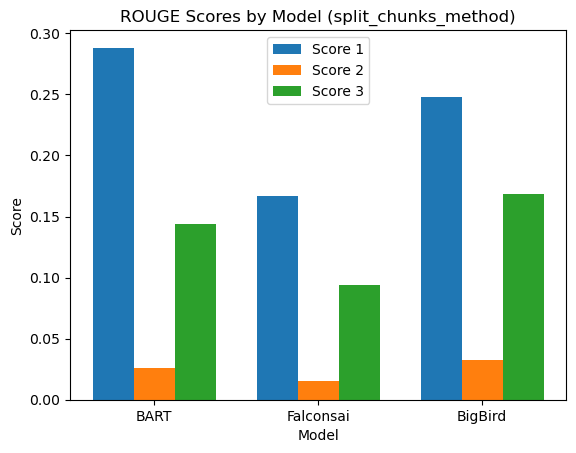

In [47]:
# Create a chart to compare the scores

models = ["BART", "Falconsai", "BigBird"]
scores_1 = [bart_scores["rouge1"], falconsai_scores["rouge1"], bigbird_scores["rouge1"]]
scores_2 = [bart_scores["rouge2"], falconsai_scores["rouge2"], bigbird_scores["rouge2"]]
scores_l = [bart_scores["rougeL"], falconsai_scores["rougeL"], bigbird_scores["rougeL"]]
scores = [scores_1, scores_2, scores_l]

fig, ax = plt.subplots()
bar_width = 0.25
index = range(len(models))

for i, score in enumerate(scores):
    ax.bar([x + bar_width * i for x in index], score, bar_width, label=f"Score {i + 1}")

ax.set_xlabel("Model")
ax.set_ylabel("Score")
ax.set_title("ROUGE Scores by Model (split_chunks_method)")
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(models)
ax.legend()

plt.show()

In [48]:
# extract the article_id, abstract, and full_text columns into a new DataFrame
df_nlp = df_articles[["article_id", "full_text", "ABSTRACT"]]
df_nlp.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [49]:
# save the dataframe to a .csv file
df_nlp.to_csv("articles.csv", index=False)

In [50]:
from datasets import Dataset, DatasetDict

# Split into training and test datasets
train_df, test_df = train_test_split(df_nlp, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Combine the training and test datasets
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Print the dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__'],
        num_rows: 100
    })
})


### Fine-tuning LLM for our use case


In [51]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, TrainingArguments, Trainer

In [52]:
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [53]:
def tokenize(batch: dict, max_length: int = 1024, padding: str = "max_length", return_tensors: str = "pt"):
    """
    Tokenizes the input and target text from the batch using the specified tokenizer.

    Args:
        batch (dict): A dictionary containing the input and target text with keys "full_text" and "ABSTRACT".
        max_length (int, optional): The maximum length of the tokenized sequences. Defaults to 1024.
        padding (str, optional): Padding strategy. Defaults to "max_length".
        return_tensors (str, optional): The type of tensors to return. Defaults to "pt".

    Returns:
        dict: The tokenized and encoded representations of the input and target texts.
    """
    try:
        encoding = tokenizer(
            batch["full_text"],
            text_target=batch["ABSTRACT"],
            max_length=max_length,
            truncation=True,
            padding=padding,
            return_tensors=return_tensors,
        )
        return encoding
    except KeyError as e:
        raise ValueError(f"Missing key in batch: {e}")

In [54]:
# Tokenize the dataset with a maximum 512 tokens to prevent memory issues on GPU for initial testing
article_pt = dataset.map(lambda batch: tokenize(batch, max_length=512), batched=True, batch_size=None)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [55]:
article_pt

DatasetDict({
    train: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 400
    })
    test: Dataset({
        features: ['article_id', 'full_text', 'ABSTRACT', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [56]:
# Create a data collator that will handle the preprocessing of the input data for the Seq2Seq model
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define the training arguments, including the output directory, number of epochs, batch sizes, and other hyperparameters
args = TrainingArguments(
    output_dir="train_dir",  # Directory to save the model checkpoints and other artifacts
    num_train_epochs=2,  # Number of training epochs
    per_device_train_batch_size=4,  # Batch size for training
    per_device_eval_batch_size=4,  # Batch size for evaluation
    eval_strategy='epoch',  # Evaluate the model after each epoch
    save_strategy='epoch',  # Save the model checkpoints after each epoch
    weight_decay=0.01,  # L2 regularization strength
    learning_rate=2e-5,  # Learning rate for the optimizer
    gradient_accumulation_steps=500  # Number of gradient accumulation steps
)

# Create a Trainer instance that will handle the training process
trainer = Trainer(
    model=model,  # The Seq2Seq model to be trained
    args=args,  # The training arguments
    tokenizer=tokenizer,  # The tokenizer used for the input data
    data_collator=data_collator,  # The data collator for preprocessing the input data
    train_dataset=article_pt['train'],  # The training dataset
    eval_dataset=article_pt['test']  # The evaluation dataset
)

# Start the training process
trainer.train()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 5.6242594718933105, 'eval_runtime': 111.7806, 'eval_samples_per_second': 0.895, 'eval_steps_per_second': 0.224, 'epoch': 1.0}


c:\Users\stanl\anaconda3\Lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 5.446699619293213, 'eval_runtime': 65.1322, 'eval_samples_per_second': 1.535, 'eval_steps_per_second': 0.384, 'epoch': 2.0}
{'train_runtime': 3550.8463, 'train_samples_per_second': 0.225, 'train_steps_per_second': 0.001, 'train_loss': 1.2220890522003174, 'epoch': 2.0}


TrainOutput(global_step=2, training_loss=1.2220890522003174, metrics={'train_runtime': 3550.8463, 'train_samples_per_second': 0.225, 'train_steps_per_second': 0.001, 'total_flos': 866841840844800.0, 'train_loss': 1.2220890522003174, 'epoch': 2.0})

In [57]:
# Save the trained model
trainer.save_model("research_summarization_model_bart")

In [58]:
# Load the trained model
model = AutoModelForSeq2SeqLM.from_pretrained("research_summarization_model_bart").to(device)

c:\Users\stanl\anaconda3\Lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [60]:
# Summarize the article using the trained bart model
tokenizer = AutoTokenizer.from_pretrained(model_name)
summarization_pipeline = pipeline("summarization", model=model_name, device=device)

# use the sliding window summarization method to summarize the article
summary = sliding_window_summarization(
    text=article,
    tokenizer=tokenizer,
    pipe=summarization_pipeline,
    max_length=512,
    overlap=128,
    redundancy_threshold=0.8,
    summary_length=900,
)

print("Summary:")
print(wrapper.fill(summary))

c:\Users\stanl\OneDrive\Documents\codes\research_summarizer\research_summarizer\summarization.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(previous_summary_embedding).clone().detach()


Skipping redundant summary (similarity 0.869)
Skipping redundant summary (similarity 0.936)
Skipping redundant summary (similarity 0.867)
Skipping redundant summary (similarity 0.942)
Skipping redundant summary (similarity 0.816)
Skipping redundant summary (similarity 0.990)
Skipping redundant summary (similarity 0.867)
Summary:
Alzheimer’s disease (AD) and several other neuropsychiatric disorders are among
the most significant unsolved medical and social problems. Despite intensive
studies and significant progress in genetics and molecular biology, the
pathomechanism/pathogenesis of AD and most other
neurodegenerative/neuropsychiatric diseases has not been fully elucidated. In
all these diseases, alterations in peroxisome proliferator-activated receptor
(PPAR-α, PPAR-γ) signaling may play a crucial pathogenic role.  PPAR-α is
engaged in cholesterol metabolism and the biosynthesis of neurosteroids. The
receptor plays a crucial role in neurotransmission processes in glutamatergic,
choli

In [61]:
# Evaluate the trained model on the first article
rouge = evaluate.load("rouge")
trained_sw_scores = rouge.compute(predictions=[summary], references=[df["ABSTRACT"][0]])
print(trained_sw_scores)

{'rouge1': 0.21374045801526717, 'rouge2': 0.010230179028132993, 'rougeL': 0.13231552162849872, 'rougeLsum': 0.13231552162849872}
